In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import json
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib
from joblib import Memory

from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import (
    expand_feature_list,
    load_data_from_database,
    prepare_data,
)
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.make_model_plots import InferenceCache
from src.plots.model_inference import (
    _process_confidence_data,
    analyze_test_dataset_for_one_stimulus,
    plot_prediction_confidence_heatmap,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)


18:22:30 | DEBUG   | root | Cache hit: eda_raw_heart_rate_pupil_inference_probabilities_seeds_133_243_265_396_467_658_681_743_806_841_870_952_step_size_250


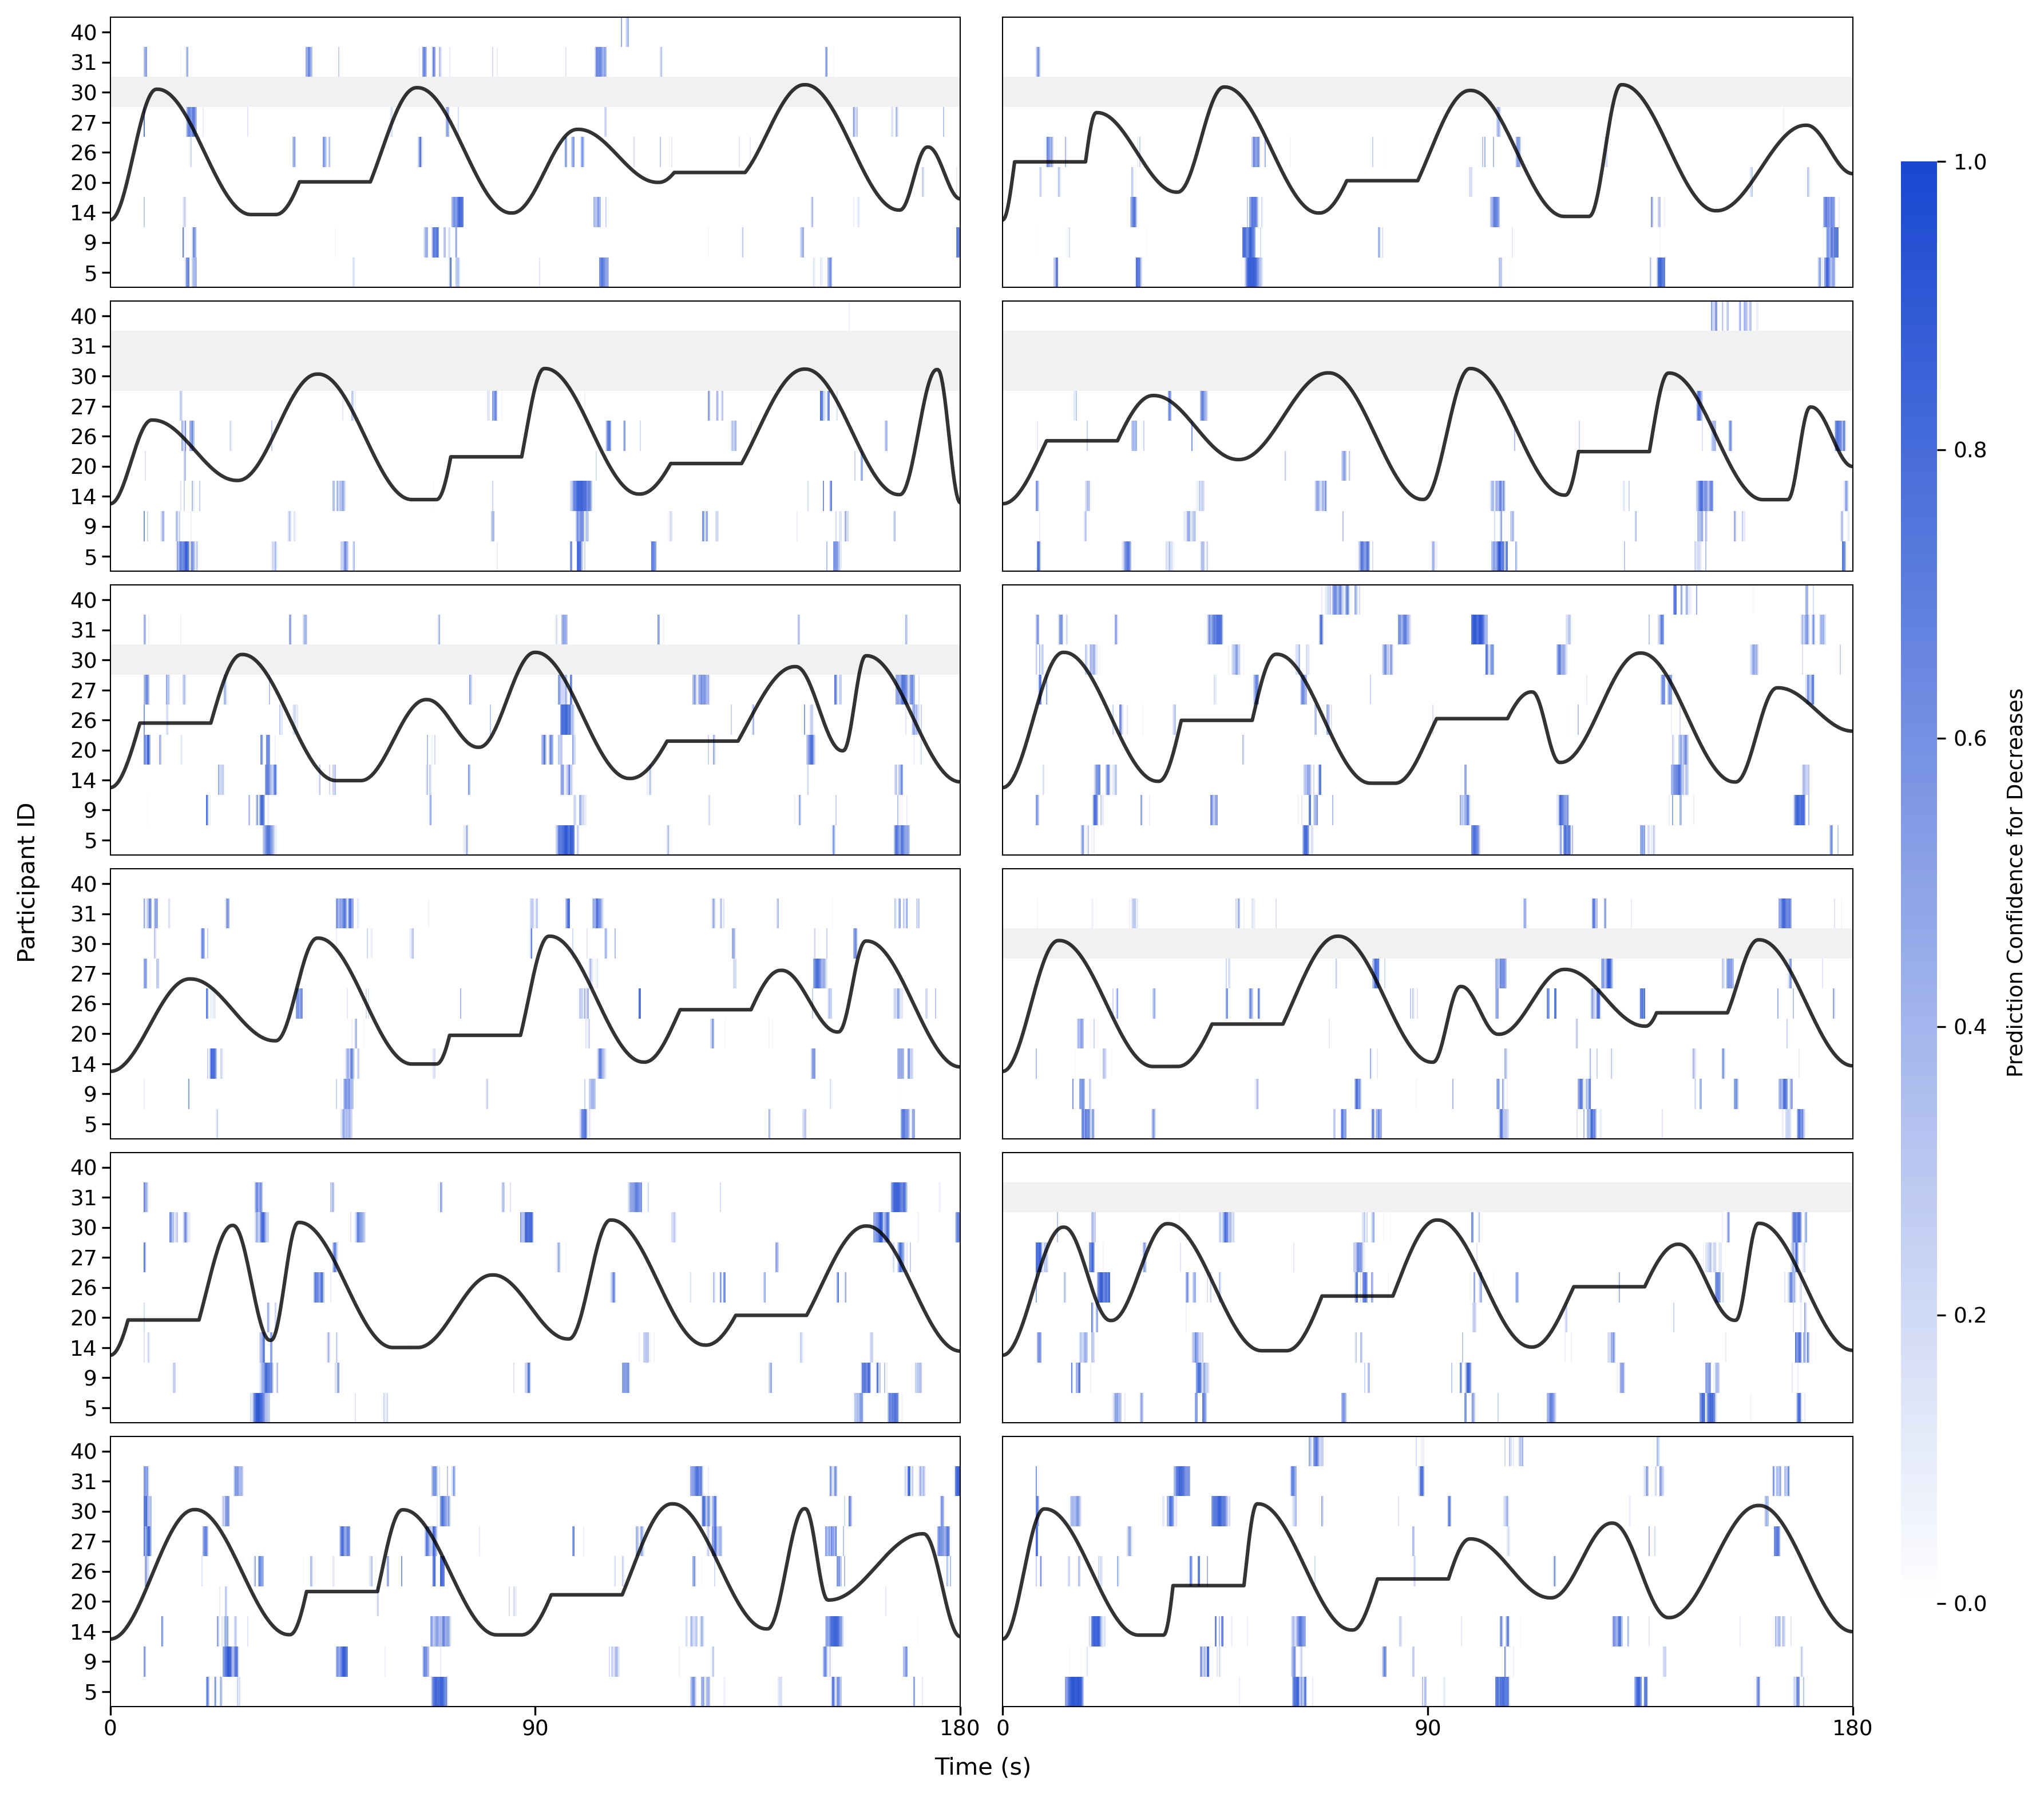

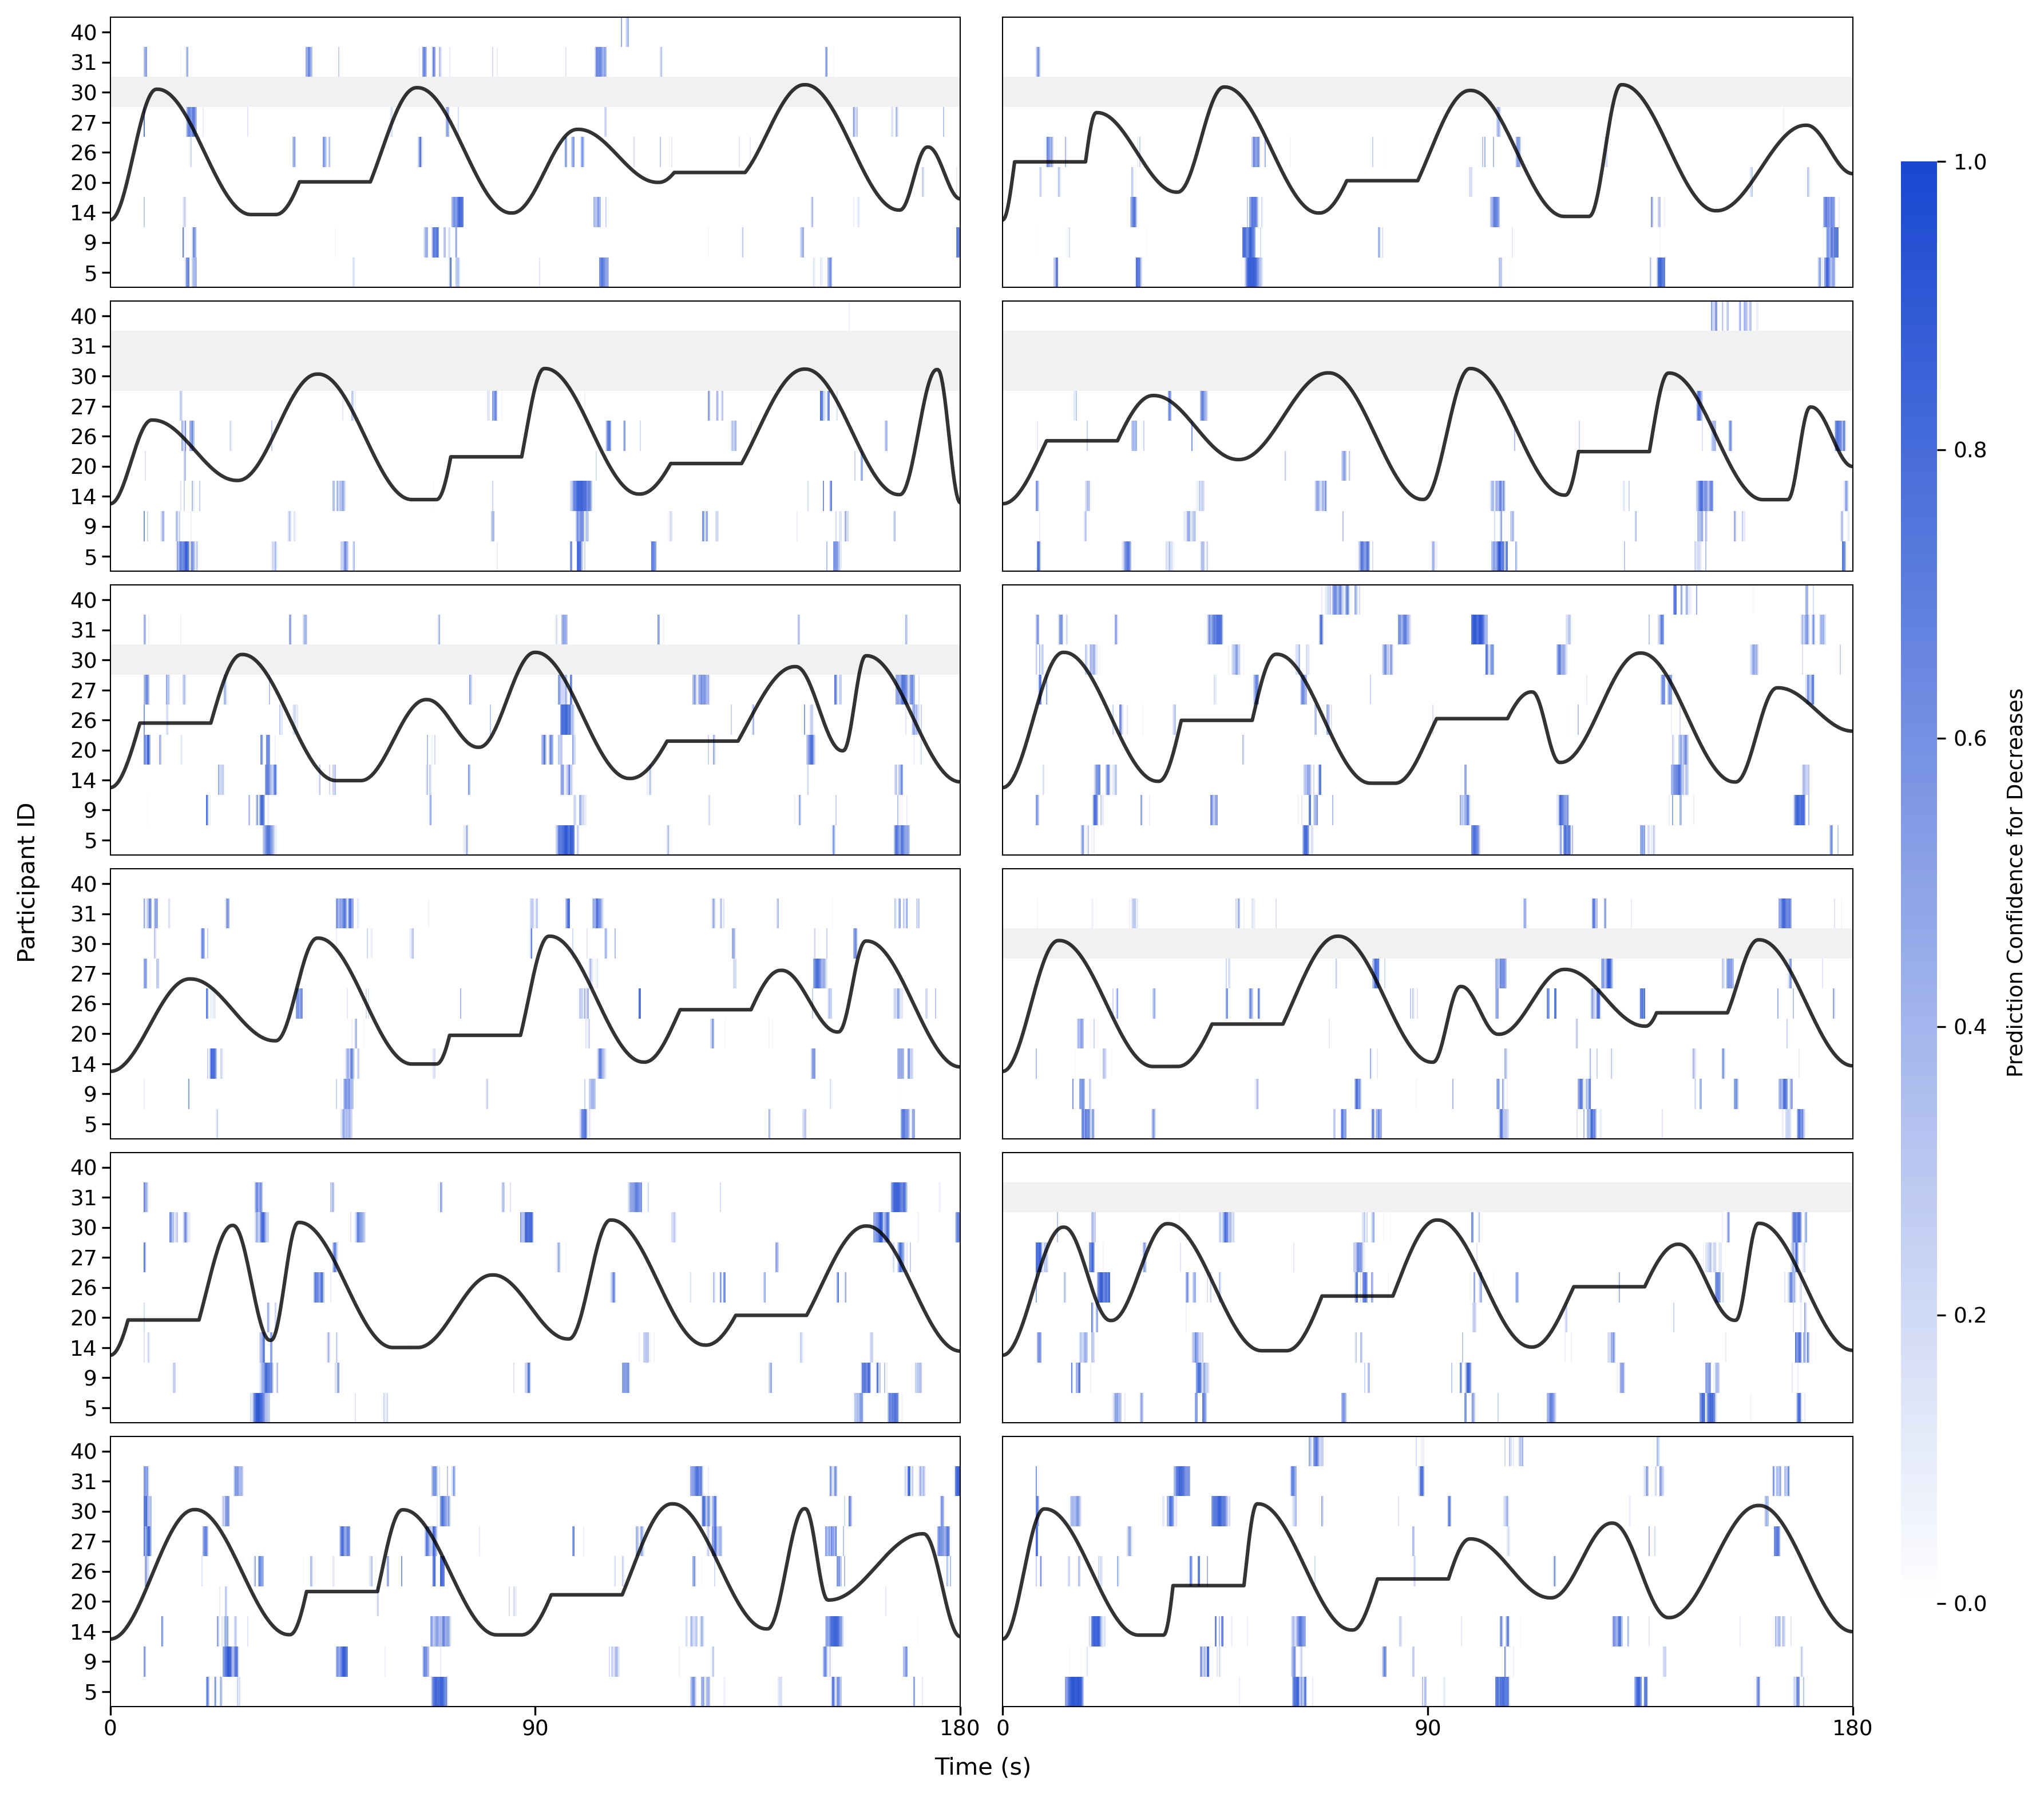

In [3]:
feature_lists = [
    # ["eda_raw"],
    # ["heart_rate"],
    # ["pupil"],
    # ["eda_raw", "heart_rate"],
    # ["eda_raw", "pupil"],
    ["eda_raw", "heart_rate", "pupil"],
    # ["face"],
    # ["face", "eda_raw", "heart_rate", "pupil"],
    # ["eeg"],
    # ["eeg", "eda_raw"],
    # ["eeg", "face", "eda_raw", "heart_rate", "pupil"],
]
# feature_lists = [["eda_raw", "heart_rate", "pupil"]]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[0]
feature_list_str = "_".join(feature_list)

config_path = Path("src/experiments/measurement/measurement_config.toml")
with open(config_path, "rb") as file:
    config = tomllib.load(file)
stimulus_seeds = config["stimulus"]["seeds"]

step_size = 250  # in ms

cache = InferenceCache()
cached_results = cache.get(
    feature_list_str,
    "inference_probabilities",
    seeds=tuple(stimulus_seeds),
    step_size=step_size,
)["probabilities"]

classification_threshold = 0.9

plot_prediction_confidence_heatmap(
    all_probabilities=cached_results,
    sample_duration=7000,
    classification_threshold=classification_threshold,
    only_decreases=True,
    seeds_to_plot=stimulus_seeds,
    step_size=step_size,
    ncols=2,
    figure_size=(7, 2),
    stimulus_scale=0.5,
    stimulus_linewidth=1.5,
)

18:22:32 | DEBUG   | root | Cache hit: eda_raw_heart_rate_pupil_inference_probabilities_seeds_133_243_265_396_467_658_681_743_806_841_870_952_step_size_250


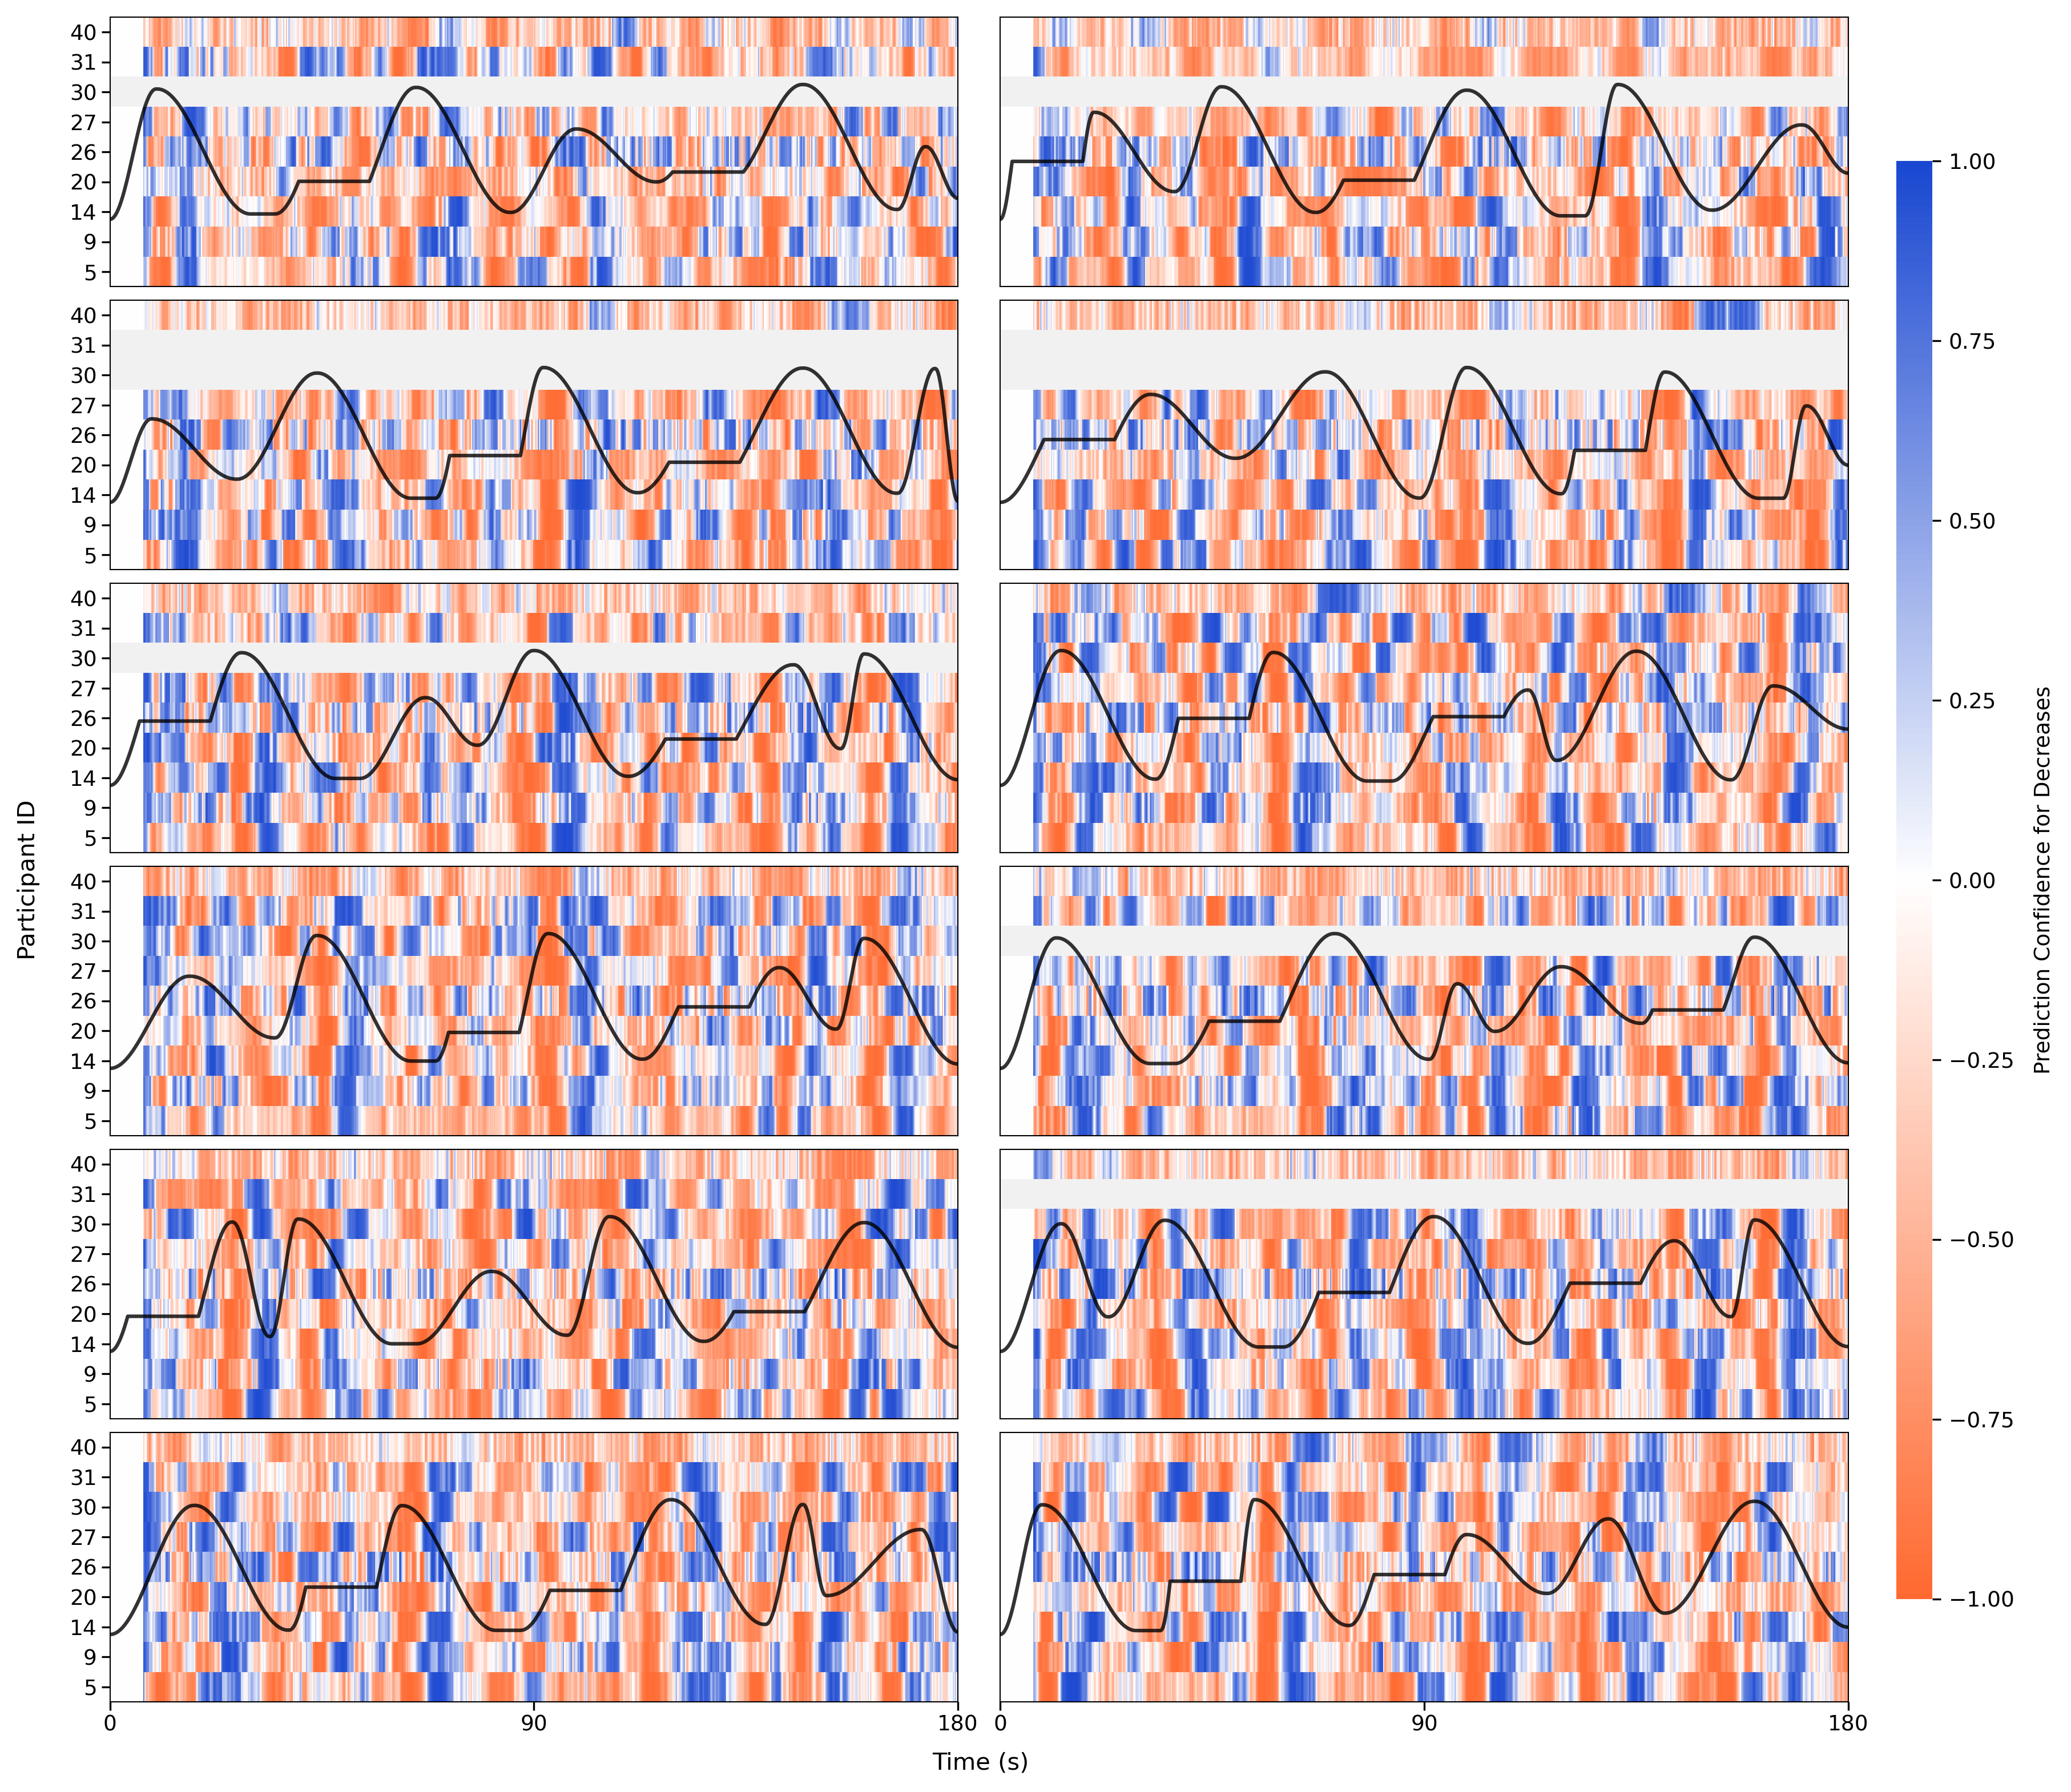

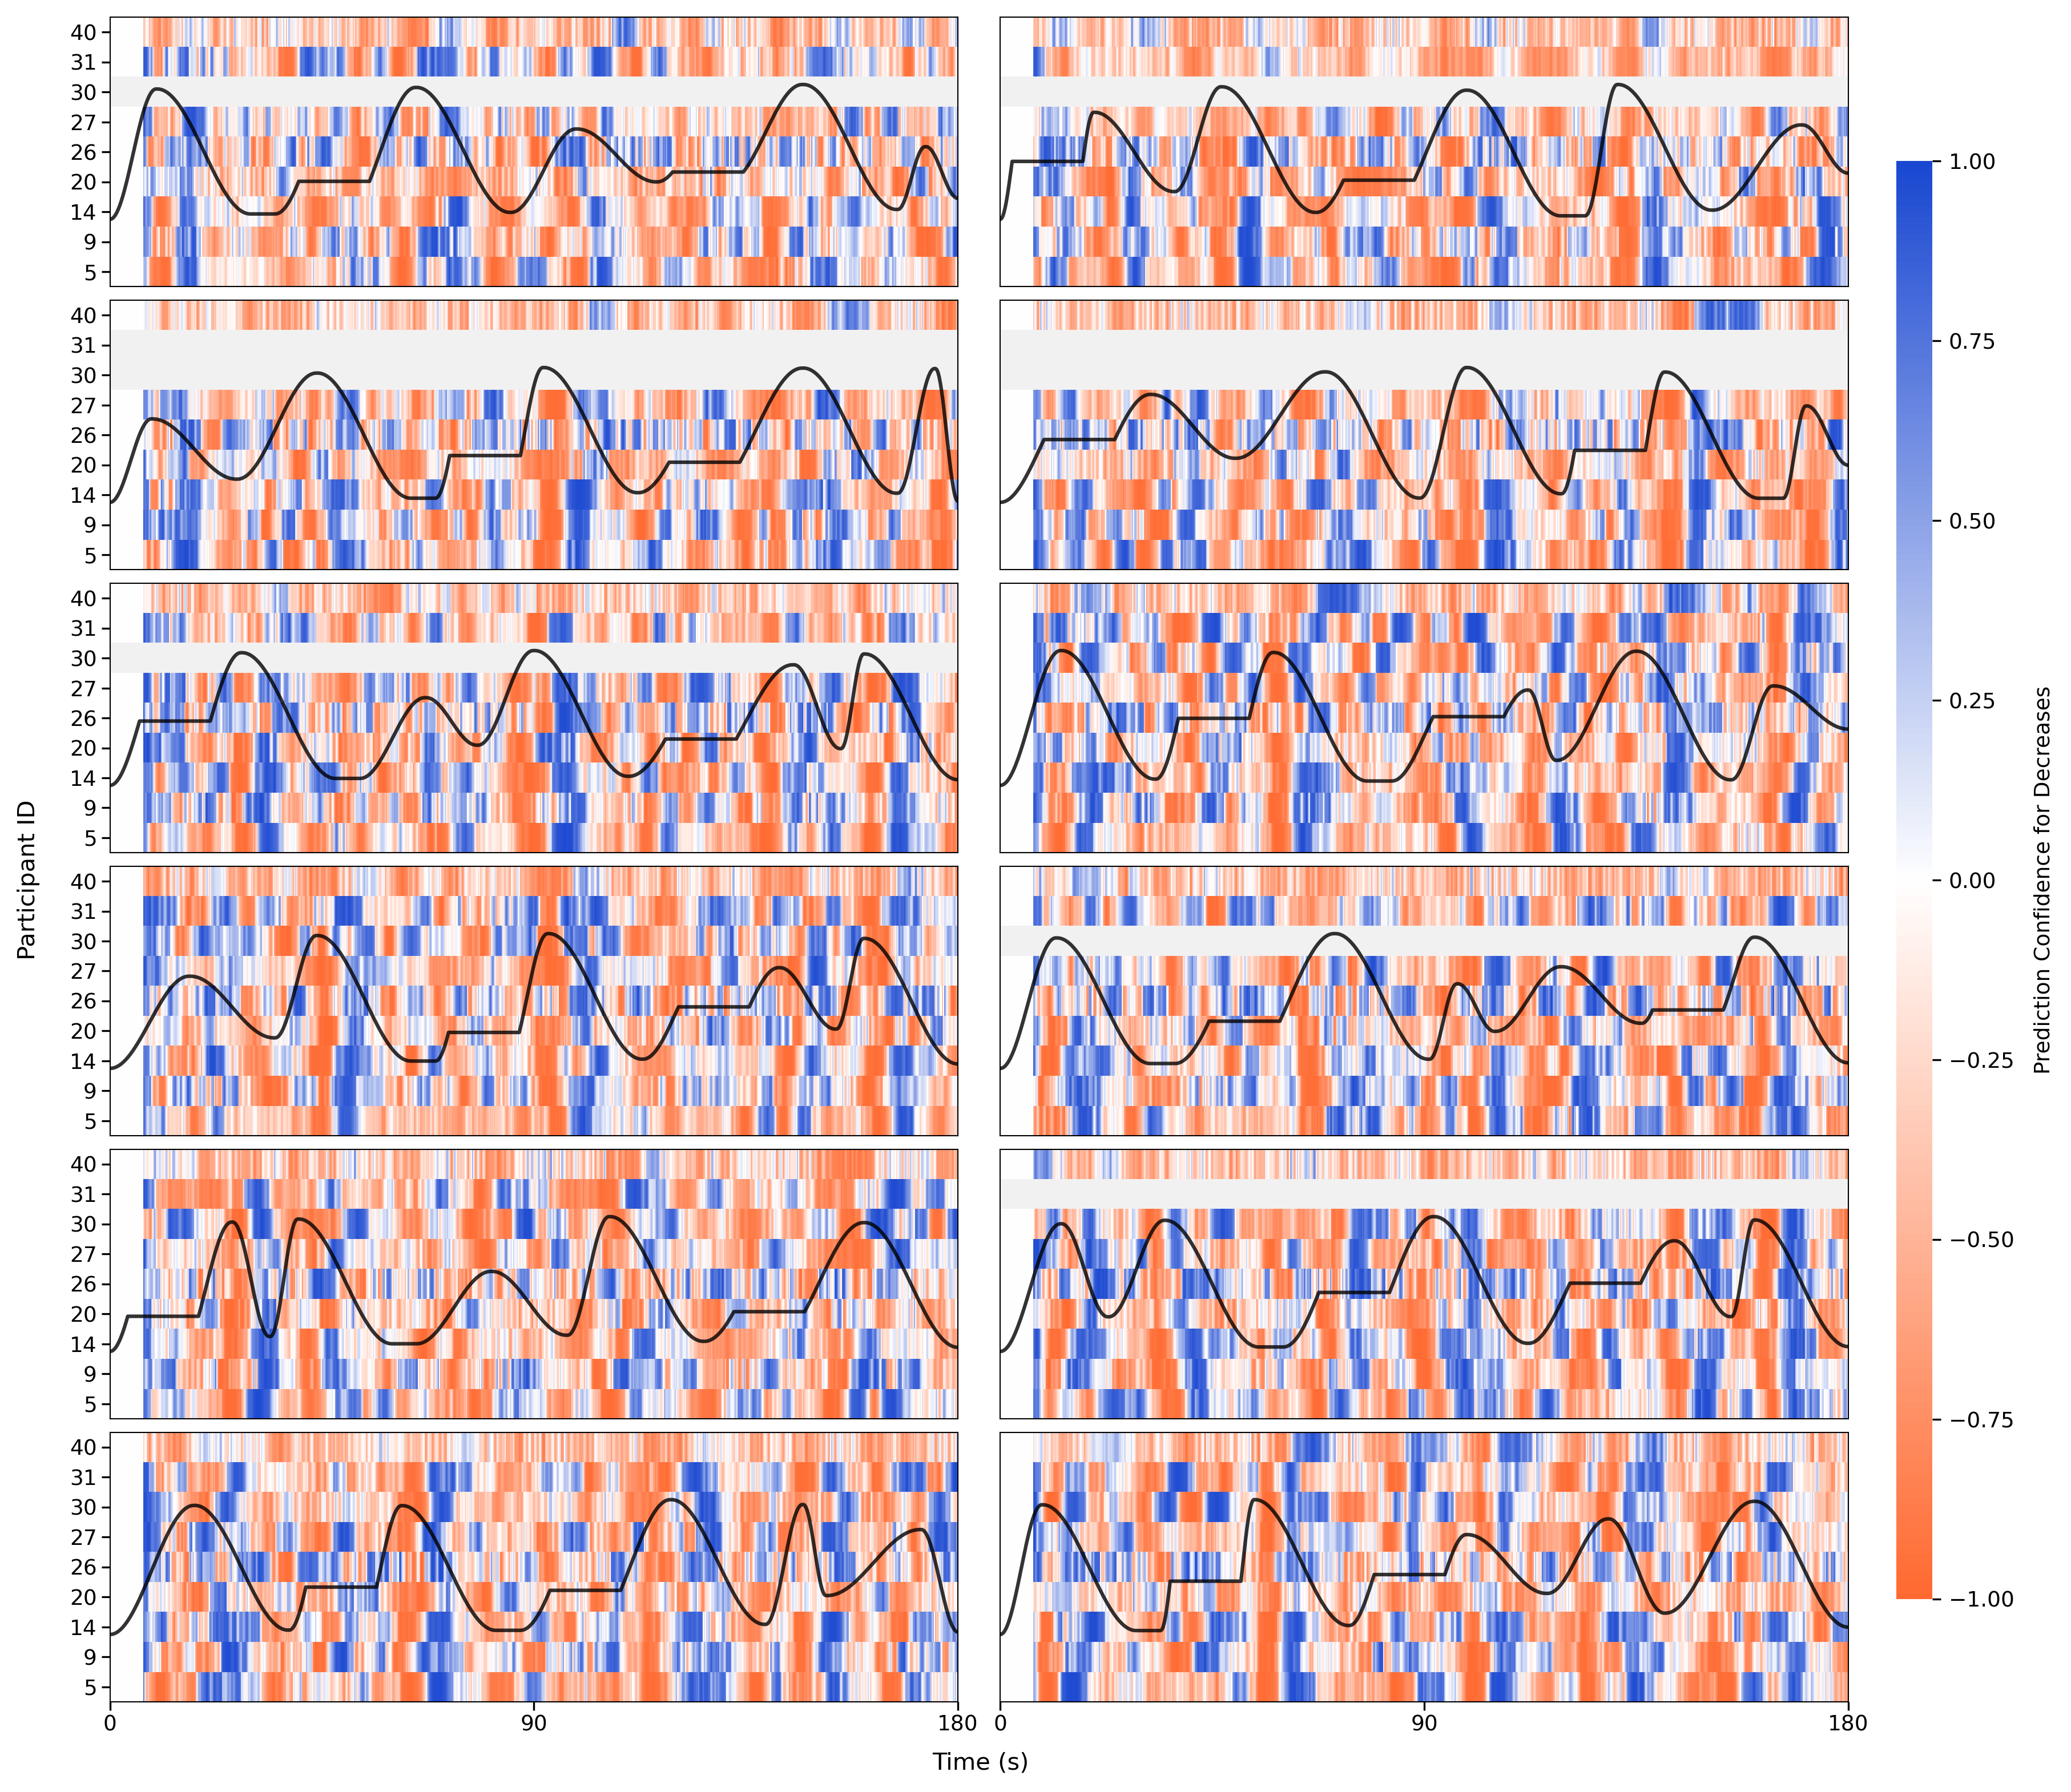

In [4]:
feature_lists = [
    # ["eda_raw"],
    # ["heart_rate"],
    # ["pupil"],
    # ["eda_raw", "heart_rate"],
    # ["eda_raw", "pupil"],
    ["eda_raw", "heart_rate", "pupil"],
    # ["face"],
    # ["face", "eda_raw", "heart_rate", "pupil"],
    # ["eeg"],
    # ["eeg", "eda_raw"],
    # ["eeg", "face", "eda_raw", "heart_rate", "pupil"],
]
# feature_lists = [["eda_raw", "heart_rate", "pupil"]]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[0]
feature_list_str = "_".join(feature_list)

config_path = Path("src/experiments/measurement/measurement_config.toml")
with open(config_path, "rb") as file:
    config = tomllib.load(file)
stimulus_seeds = config["stimulus"]["seeds"]

step_size = 250  # in ms

cache = InferenceCache()
cached_results = cache.get(
    feature_list_str,
    "inference_probabilities",
    seeds=tuple(stimulus_seeds),
    step_size=step_size,
)["probabilities"]

classification_threshold = 0.5

plot_prediction_confidence_heatmap(
    all_probabilities=cached_results,
    sample_duration=7000,
    classification_threshold=classification_threshold,
    only_decreases=False,
    seeds_to_plot=stimulus_seeds,
    step_size=step_size,
    ncols=2,
    figure_size=(7, 2),
    stimulus_scale=0.5,
    stimulus_linewidth=1.5,
)

18:22:34 | DEBUG   | root | Cache hit: eda_raw_heart_rate_pupil_inference_probabilities_seeds_133_243_265_396_467_658_681_743_806_841_870_952_step_size_250
Number of detections: 209
Mean delay: 5.93 seconds
Median delay: 5.75 seconds
Standard deviation: 2.62 seconds
MAD: 1.50 seconds
IQR: 3.00 seconds
Min delay: 1.25 seconds
Max delay: 17.25 seconds
Number of delays: 209


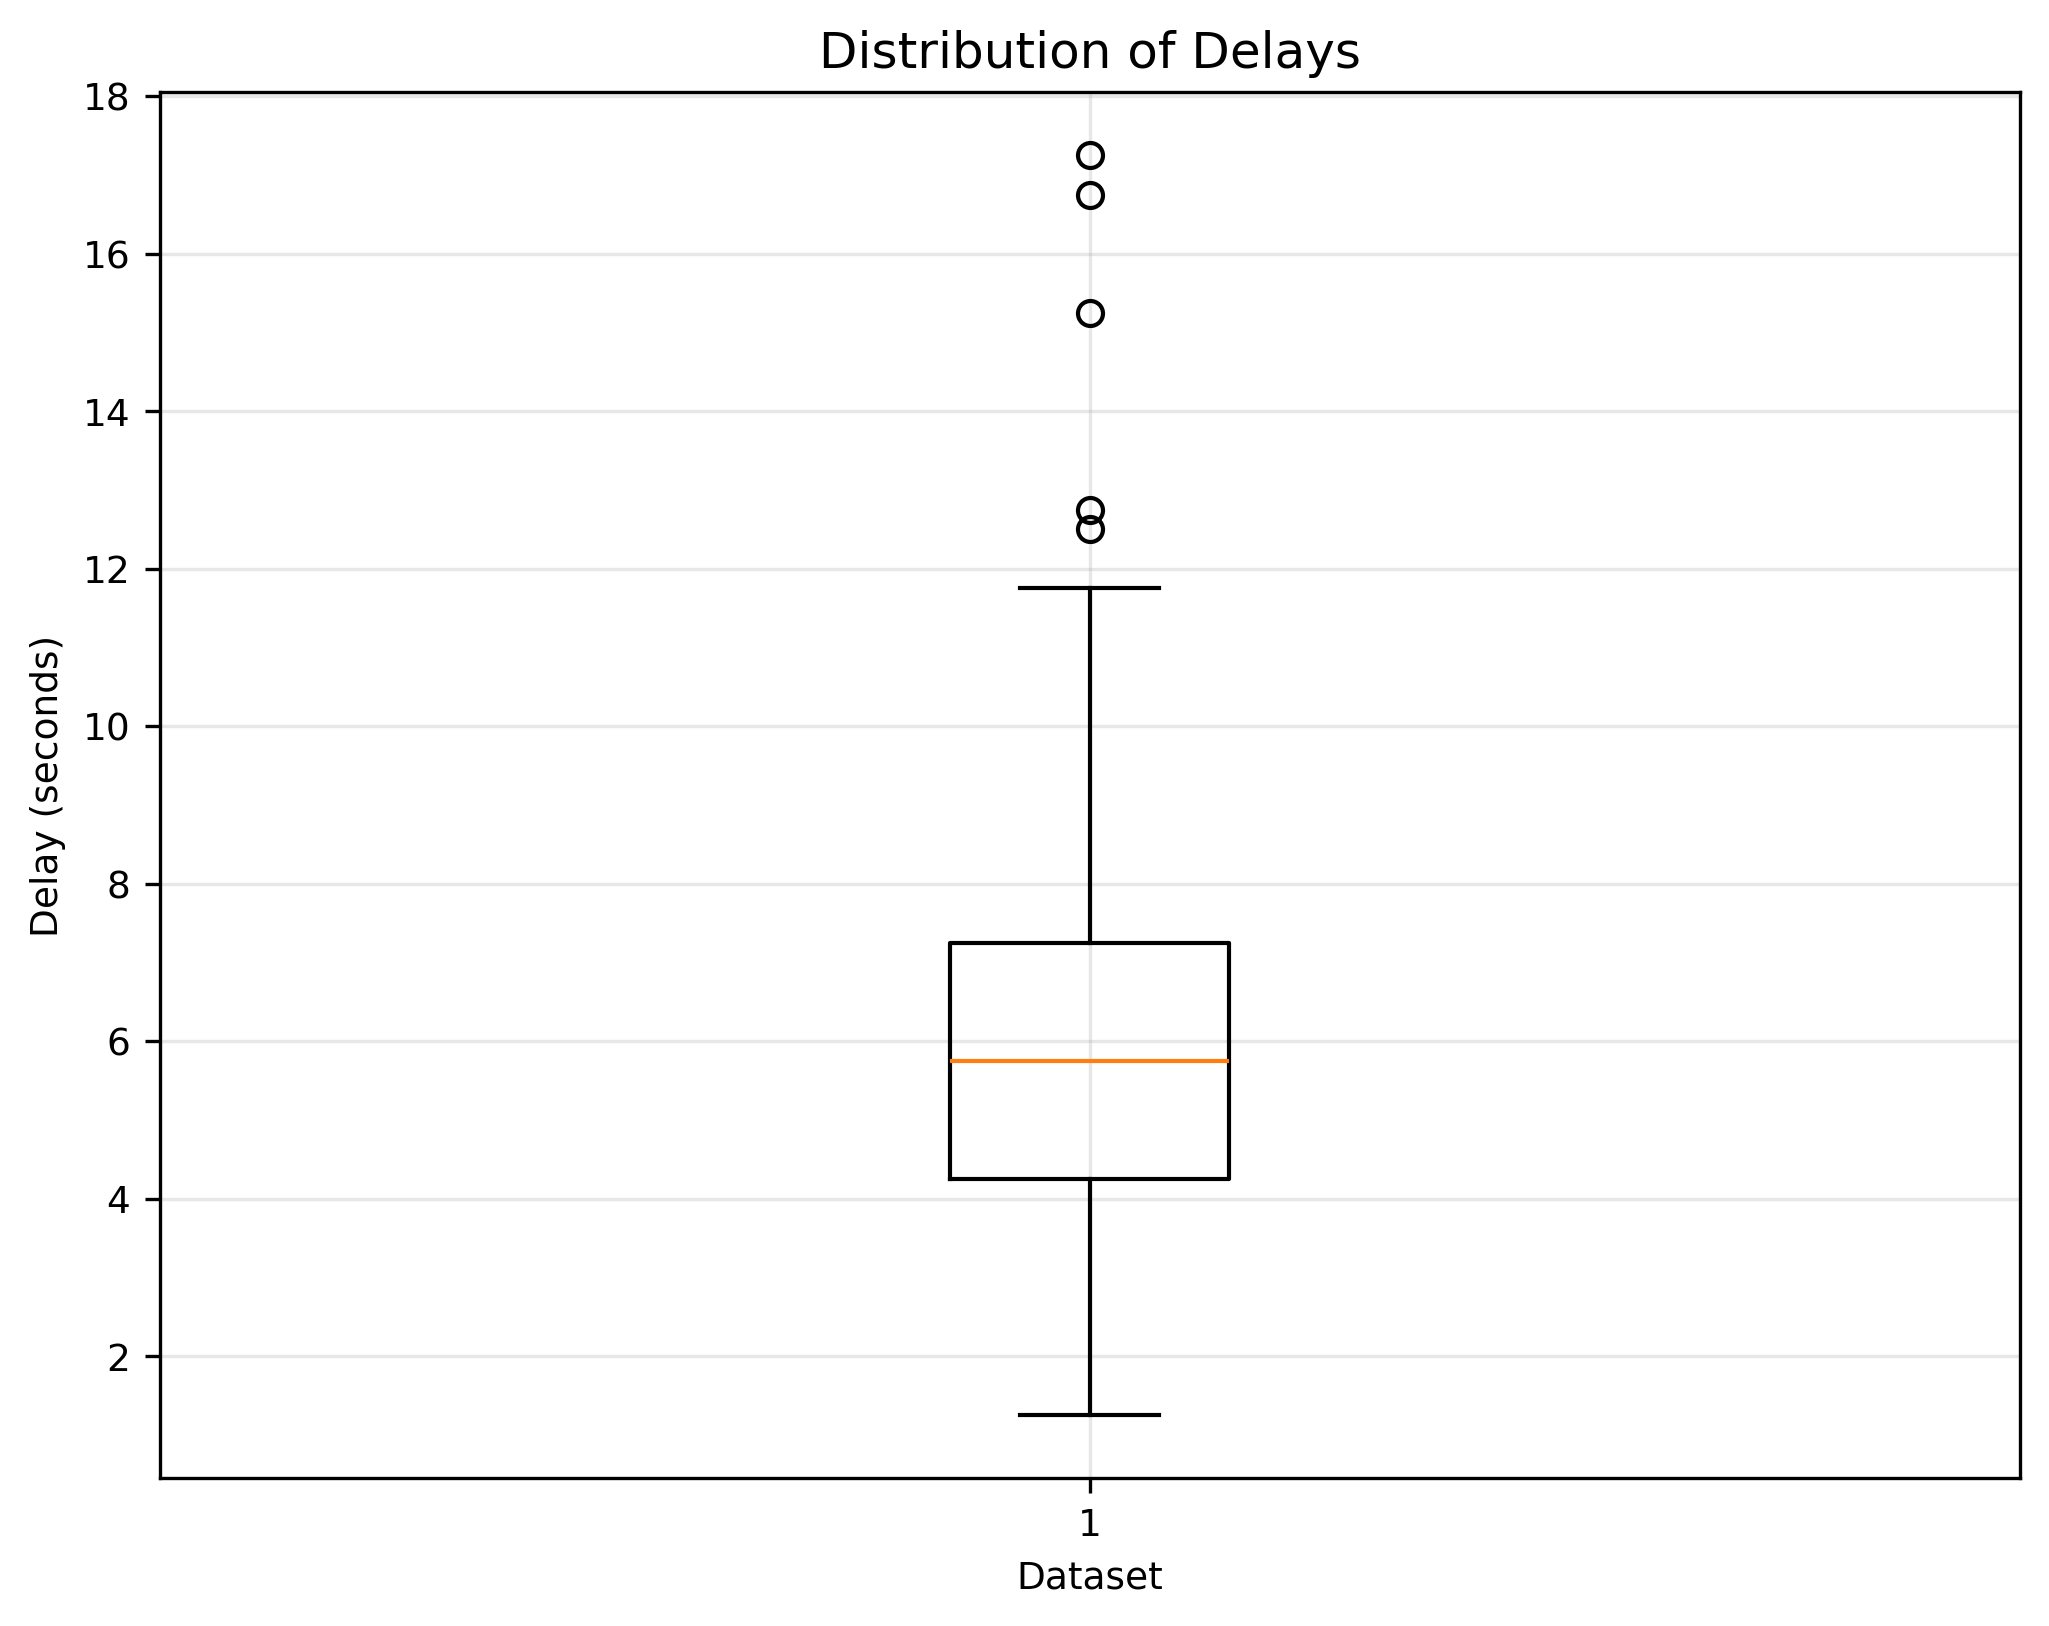

In [5]:
cache = InferenceCache()
cached_results = cache.get(
    feature_list_str,
    "inference_probabilities",
    seeds=tuple(stimulus_seeds),
    step_size=step_size,
)["probabilities"]

classification_threshold = 0.9


delays = []
for stimulus_seed in stimulus_seeds:
    stim = StimulusGenerator(
        seed=stimulus_seed, config=dict(sample_rate=1000 / step_size)
    )
    interval_idxs = stim.major_decreasing_intervals_idx
    # only use stim.major_decreasing_intervals_idx because those are the longer decreases
    # note that some of the shorter decreases were detected after their interval
    # ended, so they would not be detected here

    results, participants = _process_confidence_data(
        cached_results[stimulus_seed],
        classification_threshold,
        sample_duration=7000,
        step_size=step_size,
    )
    for idx, participant in enumerate(participants):
        for interval_idx in interval_idxs:
            predictions = results[idx][interval_idx[0] : interval_idx[1]]
            if any(predictions > 0):
                # Find the first index where prediction exceeds 0
                delay = np.argmax(predictions > 0)  # argmax gives the first occurrence
                delays.append(delay)

delays = np.array(delays)
delays = delays / (1000 / step_size)  # Convert to seconds
delays = delays[delays > 1]  # Remove delays less than 1 second

# Print some basic statistics
print(f"Number of detections: {len(delays)}")
print(f"Mean delay: {np.mean(delays):.2f} seconds")
print(f"Median delay: {np.median(delays):.2f} seconds")
print(f"Standard deviation: {np.std(delays):.2f} seconds")
print(f"MAD: {np.median(np.abs(delays - np.median(delays))):.2f} seconds")
print(f"IQR: {np.percentile(delays, 75) - np.percentile(delays, 25):.2f} seconds")
print(f"Min delay: {np.min(delays)} seconds")
print(f"Max delay: {np.max(delays)} seconds")
print(f"Number of delays: {len(delays)}")

# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(delays)
plt.title("Distribution of Delays")
plt.ylabel("Delay (seconds)")
plt.xlabel("Dataset")
plt.grid(True, alpha=0.3)
plt.show()


18:22:35 | DEBUG   | root | Cache hit: eda_raw_heart_rate_pupil_inference_probabilities_seeds_133_243_265_396_467_658_681_743_806_841_870_952_step_size_250
Number of detections: 191
Mean delay: 4.26 seconds
Median delay: 4.25 seconds
Standard deviation: 1.79 seconds
MAD: 1.25 seconds
IQR: 2.50 seconds
Min delay: 1.25 seconds
Max delay: 10.75 seconds
Number of delays: 191


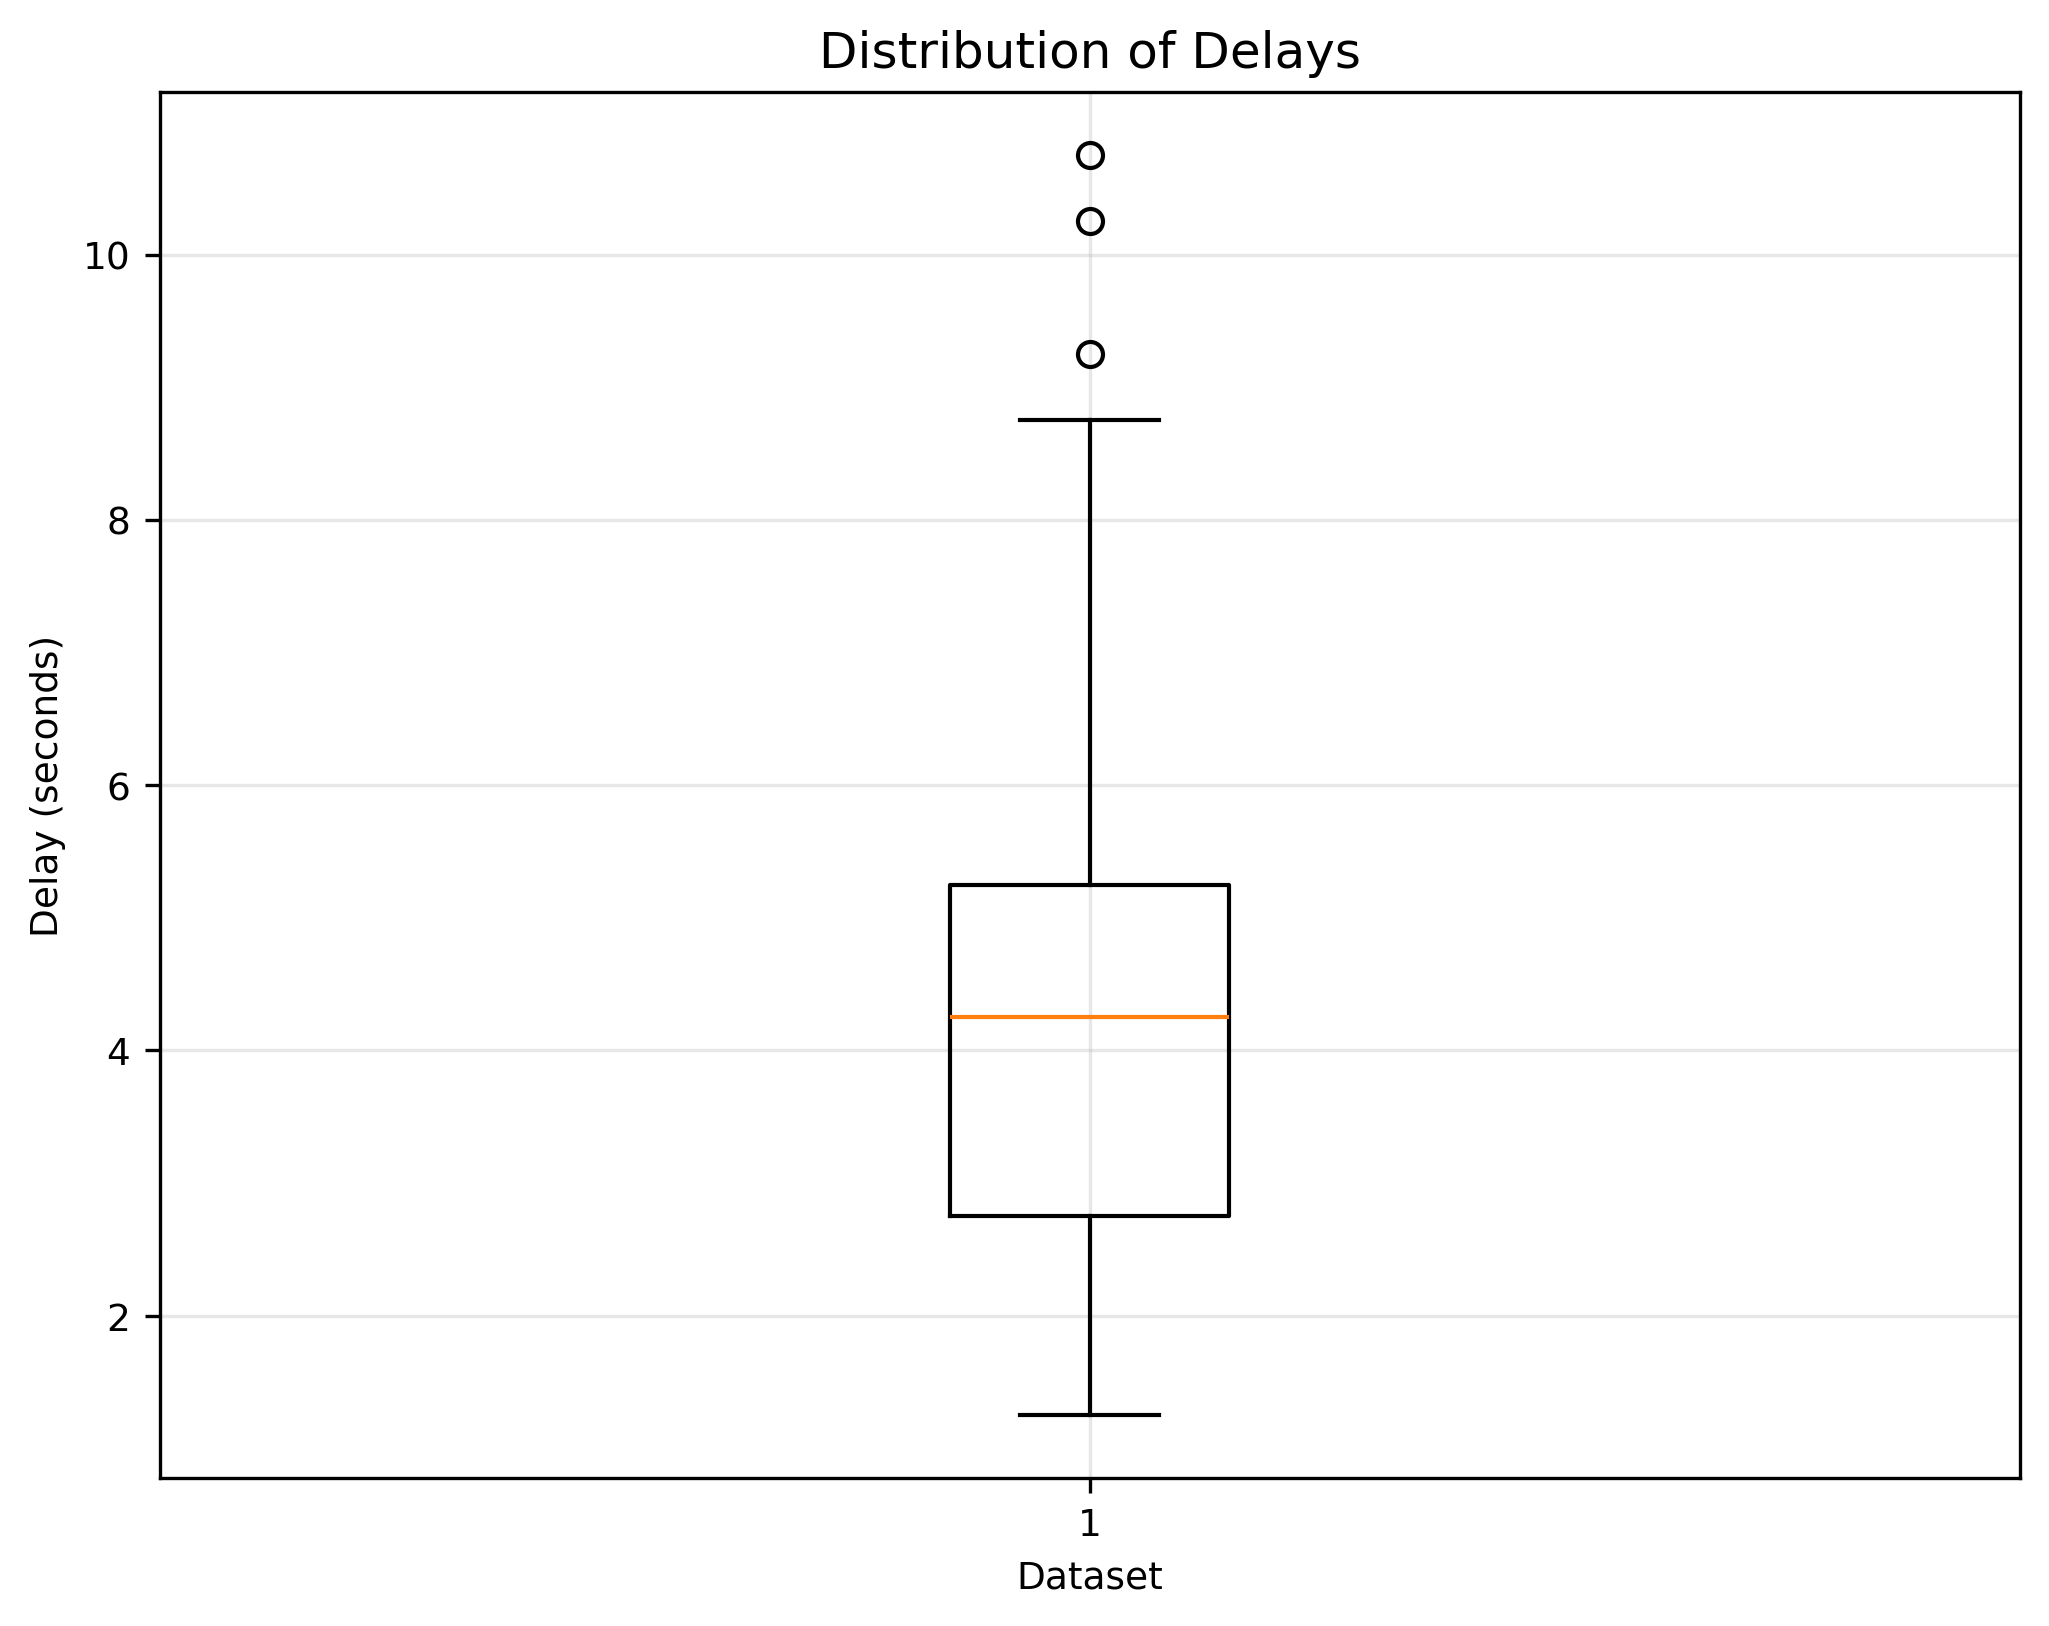

In [6]:
cache = InferenceCache()
cached_results = cache.get(
    feature_list_str,
    "inference_probabilities",
    seeds=tuple(stimulus_seeds),
    step_size=step_size,
)["probabilities"]

classification_threshold = 0.5


delays = []
for stimulus_seed in stimulus_seeds:
    stim = StimulusGenerator(
        seed=stimulus_seed, config=dict(sample_rate=1000 / step_size)
    )
    interval_idxs = stim.major_decreasing_intervals_idx
    # only use stim.major_decreasing_intervals_idx because those are the longer decreases
    # note that some of the shorter decreases were detected after their interval
    # ended, so they would not be detected here

    results, participants = _process_confidence_data(
        cached_results[stimulus_seed],
        classification_threshold,
        sample_duration=7000,
        step_size=step_size,
    )
    for idx, participant in enumerate(participants):
        for interval_idx in interval_idxs:
            predictions = results[idx][interval_idx[0] : interval_idx[1]]
            if any(predictions > 0):
                # Find the first index where prediction exceeds 0
                delay = np.argmax(predictions > 0)  # argmax gives the first occurrence
                delays.append(delay)

delays = np.array(delays)
delays = delays / (1000 / step_size)  # Convert to seconds
delays = delays[delays > 1]  # Remove delays less than 1 second

# Print some basic statistics
print(f"Number of detections: {len(delays)}")
print(f"Mean delay: {np.mean(delays):.2f} seconds")
print(f"Median delay: {np.median(delays):.2f} seconds")
print(f"Standard deviation: {np.std(delays):.2f} seconds")
print(f"MAD: {np.median(np.abs(delays - np.median(delays))):.2f} seconds")
print(f"IQR: {np.percentile(delays, 75) - np.percentile(delays, 25):.2f} seconds")
print(f"Min delay: {np.min(delays)} seconds")
print(f"Max delay: {np.max(delays)} seconds")
print(f"Number of delays: {len(delays)}")

# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(delays)
plt.title("Distribution of Delays")
plt.ylabel("Delay (seconds)")
plt.xlabel("Dataset")
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
results[0].shape

(720,)